In [120]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import timeit

In [121]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

In [122]:
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}

# Allocate shares

In [123]:
'''
Distributes shares among a discrete allocated portfolio based on initial price, money and portfolio weights of the stock
Inputs:
    1) data - Dataframe of assets with price multiindexed column names with the highest level being the tickers and the next level
    being prc | ret | retx | retd.
    2) initial_money - Initial money to be used to purchase assets
    3) portfolio_weights - Dictionary of {tickers : weight or asset} e.g. {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
'''

def allocate_shares(data, portfolio_weights,initial_money = 10000000):
    latest_prices = {}
    date_start = data.index[0].date().isoformat()
    for k in portfolio_weights.keys():
        latest_prices[k] = data.loc[date_start][k]['prc']
        srs_latest_prices = pd.Series(latest_prices)
        
    da = DiscreteAllocation(portfolio_weights, srs_latest_prices, total_portfolio_value=initial_money)
    shares, cash = da.lp_portfolio()
    return shares, cash, srs_latest_prices, date_start

In [124]:
'''
Distributes shares among a continuous allocated portfolio based on initial price, money and portfolio weights of the stock
Inputs:
    1) data - Dataframe of assets with price multiindexed column names with the highest level being the tickers and the next level
    being prc | ret | retx | retd.
    2) initial_money - Initial money to be used to purchase assets
    3) portfolio_weights - Dictionary of {tickers : weight or asset} e.g. {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
    
Outputs: 
    1) return shares
    2) latest_prices
    3) date_start
'''

def allocate_shares_continuous(data, portfolio_weights,initial_money = 10000000):
    latest_prices = {}
    shares = {}
    date_start = data.index[0].date().isoformat()
    for k in portfolio_weights.keys():
        latest_prices[k] = data.loc[date_start][k]['prc']
        shares[k] = initial_money*portfolio_weights[k]/latest_prices[k]
    return shares, latest_prices, date_start

# Set up dataframe to track trades

In [125]:
'''
Initializes dataframes used for discrete asset allocation rebalancing, along with assets on the first day. These will be used during rebalancing to figure out the number of assets
and corresponding columns to values. The dataframes are then used when converting arrays to dataframes to establish
columns and indicies.

Inputs:
    1) shares - dictionary of the quantity of each share.
    2) cash - Money leftover or in cash reserves
    3) latest_prices - The prices on the first day

Outputs:
    1) df_trades_initial
    2) df_cash_initial 
    3) df_portfolio_sum_initial
    4) df_portfolio_detail_initial
'''

def initialize_df(data, portfolio_weights,initial_money=1000000):
    shares, cash, srs_latest_prices, date_start = allocate_shares(data, portfolio_weights,initial_money)
    ls_trades = []
    ls_tickers = []
    ls_labels = ['shr chg', 'prc', 'csh chg', 'tot shr', 'tot bal', 'divflag', 'rebalflag']
    for k in srs_latest_prices.index:
        ls_trades = ls_trades + [shares[k], srs_latest_prices[k], -shares[k]*srs_latest_prices[k], shares[k], shares[k]*srs_latest_prices[k],0, 0]
        ls_tickers.append(k)
    ls_trades_iterables = [ls_tickers, ls_labels]
    trades_columns = pd.MultiIndex.from_product(ls_trades_iterables, names=['ticker', 'metric'])
    df_trades_initial = pd.DataFrame(np.array([ls_trades]),columns=trades_columns, index = [date_start])
    
    #Initialize df_cash dataframe
    df_cash_initial = pd.DataFrame(cash, columns = ['cash'], index = [date_start])
    
    #Initialize df_portfolio_detail dataframe
    ls_port_det_int_labels = ['price', 'return', 'weight', 'shares', 'value']
    ls_port_det_int_iterables = [ls_tickers, ls_port_det_int_labels]
    columns = pd.MultiIndex.from_product(ls_port_det_int_iterables, names=['ticker', 'metric'])
    df_portfolio_detail_initial = pd.DataFrame(columns=columns)

    #Initialize df_portfolio_sum dataframe
    ls_port_sum_labels = ['total_value', 'asset_value', 'cash', 'cash_pct']
    df_portfolio_sum_initial = pd.DataFrame(columns=ls_port_sum_labels)



    return df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial

In [126]:
'''
Initializes dataframes used for continuous asset allocation rebalancing, along with assets on the first day. These will be used during rebalancing to figure out the number of assets
and corresponding columns to values. The dataframes are then used when converting arrays to dataframes to establish
columns and indicies.

Inputs:
    1) shares - dictionary of the quantity of each share.
    2) cash - Money leftover or in cash reserves
    3) latest_prices - The prices on the first day

Outputs:
    1) df_trades_initial
    2) df_cash_initial 
    3) df_portfolio_sum_initial
    4) df_portfolio_detail_initial
'''

def initialize_df_continuous(data, portfolio_weights,initial_money=1000000):
    shares, latest_prices, date_start = allocate_shares_continuous(data, portfolio_weights,initial_money)
    ls_trades = []
    ls_tickers = []
    ls_labels = ['shr chg', 'prc', 'csh chg', 'tot shr', 'tot bal', 'divflag', 'rebalflag']
    for k in latest_prices.keys():
        ls_trades = ls_trades + [shares[k], latest_prices[k], -shares[k]*latest_prices[k], shares[k], shares[k]*latest_prices[k],0, 0]
        ls_tickers.append(k)
    ls_trades_iterables = [ls_tickers, ls_labels]
    trades_columns = pd.MultiIndex.from_product(ls_trades_iterables, names=['ticker', 'metric'])
    df_trades_initial = pd.DataFrame(np.array([ls_trades]),columns=trades_columns, index = [date_start])
    
    #Initialize df_cash dataframe
    df_cash_initial = pd.DataFrame(np.array([0]), columns = ['cash'], index = [date_start])
    
    #Initialize df_portfolio_detail dataframe
    ls_port_det_int_labels = ['price', 'return', 'weight', 'shares', 'value']
    ls_port_det_int_iterables = [ls_tickers, ls_port_det_int_labels]
    columns = pd.MultiIndex.from_product(ls_port_det_int_iterables, names=['ticker', 'metric'])
    df_portfolio_detail_initial = pd.DataFrame(columns=columns)

    #Initialize df_portfolio_sum dataframe
    ls_port_sum_labels = ['total_value', 'asset_value', 'cash', 'cash_pct']
    df_portfolio_sum_initial = pd.DataFrame(columns=ls_port_sum_labels)



    return df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial

# Functions to track dividend payments and rebalance using discrete assets

In [190]:
def calendar_threshold_rebalance_discrete(data, portfolio_weights, initial_money=1000000, rebalance_days = 63, threshold = 1):
    trading_day_counter = 1
    df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df(data, portfolio_weights,initial_money= 1000000)
    arr_trades = np.append([[0]], np.array(df_trades), axis = 1)
    date_start = data.index[0].date().isoformat()
    arr_data_columns = data.columns.values
    arr_trades_columns = df_trades.columns.values
    arr_data = np.array(data)
    arr_cash = np.array(df_cash)
    arr_port_det = np.zeros([data.shape[0], df_portfolio_detail.shape[1]])
    arr_port_sum = np.zeros([data.shape[0], df_portfolio_sum.shape[1]])
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])
    ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
    ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
    ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
    ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
    ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']

    ls_trades_shr_index = [x+1 for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

    arr_yesterday_prices =  arr_data[0][ls_prc_index]
    cash = df_cash.iloc[0][0]
    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
    arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
    count = 0
    for row in arr_data:
        arr_leftover_cash = 0
        tradeflag = 0
        arr_divflag = np.zeros(len(ls_tickers))
        arr_div_cash = np.zeros(len(ls_tickers))
        arr_rebal = np.zeros(len(ls_tickers))
        arr_new_shares = np.zeros(len(ls_tickers))
        arr_latest_prices = row[ls_prc_index]    
        #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
        #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
        #that payed the dividend
        
        if np.any(row[ls_retd_index]>0):
            arr_divflag = (row[ls_retd_index]>0).astype(int)
            add_cash = arr_cash[-1]/sum(arr_divflag)
            arr_add_cash = arr_divflag*add_cash
            arr_div_cash = (arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index])+arr_add_cash
            arr_new_shares = np.floor(arr_div_cash/arr_latest_prices)
            arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)
            
        #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
        #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
        #puts the asset over the threshold.
        
        if 1 in arr_divflag:

            arr_div_flag_add = np.array([count]) 
            for i in range(len(ls_tickers)):
                arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
            arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
            arr_cash = np.append(arr_cash, [np.array([np.sum(arr_leftover_cash)])], axis=0)
            arr_divflag = np.zeros(len(ls_tickers))
            arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
            
        total_value = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
        arr_asset_val = (arr_cur_shrs * arr_latest_prices)
        arr_actual_weights = arr_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)
        
        '''Checks two things:
                1) Calendar Rebalancing: If rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
                and reblances using the original weights and the total value available. The share amount before rebalancing is then
                subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.

                2) Threshold Rebalancing: if rebalancing should occur due to an asset passing the threshold. The % deviation is calculated by: 

                                       |[Actual % of portfolio] / [target % of portfolio] - 1|

                If this absolute value is greater than the threshold, rebalancing occurs. This sells all the shares and reblances 
                using the original weights and the total value available. The share amount before rebalancing is then subtracted 
                to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.'''

        
        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:
            
            tradeflag = 1
            
            total_value = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
            
            
            da = DiscreteAllocation(portfolio_weights, pd.Series(arr_latest_prices, index = ls_tickers), total_portfolio_value=total_value)
            shares, cash = da.lp_portfolio()
            arr_rebal = np.array([i for i in shares.values()])-arr_cur_shrs
            arr_trade_add = np.array([count])
            for i in range(len(ls_tickers)):
                arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
            arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
            arr_cash = np.append(arr_cash, [np.array(cash)], axis=0)
            trading_day_counter=1
            arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
            arr_new_port_det = np.array([], dtype='f8')
            arr_asset_val = (arr_cur_shrs * arr_latest_prices)
            
        else:
            trading_day_counter += 1
        
        arr_yesterday_prices = arr_latest_prices    
            
        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        
        arr_new_port_det = np.array([], dtype='f8')
        arr_asset_val = (arr_cur_shrs * arr_latest_prices)
        total_asset_value = np.sum(arr_asset_val)
        arr_actual_weights = arr_asset_val/total_value
        ls_new_port_det = []
        for i in range(len(ls_tickers)):
            
            ls_new_port_det = ls_new_port_det + [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]]

        arr_port_det[count] = ls_new_port_det
        
        arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        
        arr_port_sum[count] = arr_new_port_sum
        count += 1
    return arr_port_det, arr_port_sum, arr_trades, arr_cash

In [191]:
arr_port_det_disc, arr_port_sum_disc, arr_trades_disc, arr_cash_disc = calendar_threshold_rebalance_discrete(d, portfolio_weights, initial_money=1000000, rebalance_days = 45000, threshold = 5)

# Functions to track dividend payments and rebalance using continuous assets

The advantage is time to run. This takes 1/3 of the time to run as the discrete version, which will come into play when we are running it over 1000 simulations.

In [196]:
def calendar_threshold_rebalance_continuous(data, portfolio_weights, initial_money=1000000, rebalance_days = 63, threshold = 1):
    trading_day_counter = 1
    df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df_continuous(data, portfolio_weights,initial_money= 1000000)
    arr_trades = np.append([[0]], np.array(df_trades), axis = 1)
    date_start = data.index[0].date().isoformat()
    arr_data_columns = data.columns.values
    arr_trades_columns = df_trades.columns.values
    arr_data = np.array(data)
    arr_cash = np.array(df_cash)
    arr_port_det = np.zeros([data.shape[0], df_portfolio_detail.shape[1]])
    arr_port_sum = np.zeros([data.shape[0], df_portfolio_sum.shape[1]])
    ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
    ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
    ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
    ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
    ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])
    ls_trades_shr_index = [x+1 for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

    arr_yesterday_prices =  arr_data[0][ls_prc_index]
    
    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
    arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])

    count = 0
    for row in arr_data:
        
        tradeflag = 0
        arr_divflag = np.zeros(len(ls_tickers))
        arr_div_cash = np.zeros(len(ls_tickers))
        arr_rebal = np.zeros(len(ls_tickers))
        arr_new_shares = np.zeros(len(ls_tickers))
        arr_leftover_cash = 0
        arr_latest_prices = row[ls_prc_index]
            
        #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
        #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
        #that payed the dividend
        
        if np.any(row[ls_retd_index]>0):
            arr_divflag = (row[ls_retd_index]>0).astype(int)
            add_cash = arr_cash[-1]/sum(arr_divflag)
            arr_add_cash = arr_divflag*add_cash
            arr_div_cash = (arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index])+arr_add_cash
            arr_new_shares = arr_div_cash/arr_latest_prices
            arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)

        #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
        #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
        #puts the asset over the threshold.
        
        if 1 in arr_divflag:
    
            arr_div_flag_add = np.array([count]) 
            for i in range(len(ls_tickers)):
                arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
            arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
            arr_cash = np.append(arr_cash, [np.array([np.sum(arr_leftover_cash)])], axis=0)
            arr_divflag = np.zeros(len(ls_tickers))
            arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
         
  
        
        total_value = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
        arr_asset_val = (arr_cur_shrs * arr_latest_prices)
        arr_actual_weights = arr_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)
        
        '''Checks two things:
                1) Calendar Rebalancing: If rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
                and reblances using the original weights and the total value available. The share amount before rebalancing is then
                subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.

                2) Threshold Rebalancing: if rebalancing should occur due to an asset passing the threshold. The % deviation is calculated by: 

                                       |[Actual % of portfolio] / [target % of portfolio] - 1|

                If this absolute value is greater than the threshold, rebalancing occurs. This sells all the shares and reblances 
                using the original weights and the total value available. The share amount before rebalancing is then subtracted 
                to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.'''

        
        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:
            
            tradeflag = 1
            
            total_value = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
            
           
            arr_shares = (total_value*arr_portfolio_weights)/arr_latest_prices
     
            arr_rebal = arr_shares-arr_cur_shrs
            arr_trade_add = np.array([count])
            for i in range(len(ls_tickers)):
                arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
            arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
            arr_cash = np.append(arr_cash, np.array([[0]]), axis=0)
            trading_day_counter=1
            arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
            arr_asset_val = (arr_cur_shrs * arr_latest_prices)
            arr_actual_weights = arr_asset_val/total_value
            
        else:
            trading_day_counter += 1
        
        arr_yesterday_prices = arr_latest_prices    
        total_asset_value = np.sum(arr_asset_val)   
        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        arr_new_port_det = np.array([], dtype='f8')
        ls_new_port_det = []
        for i in range(len(ls_tickers)):
            
            ls_new_port_det = ls_new_port_det + [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]]
        arr_port_det[count] = ls_new_port_det
        
        arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        
        arr_port_sum[count] = arr_new_port_sum
        count += 1

    return arr_port_det, arr_port_sum, arr_trades, arr_cash

In [197]:
arr_port_det_cont, arr_port_sum_cont, arr_trades_cont, arr_cash_cont=calendar_threshold_rebalance_continuous(d, portfolio_weights, initial_money=1000000, rebalance_days = 45000, threshold = 5)

## array_to_dataframe turns the outputs of the rebalancing functions to dataframes

In [132]:
def array_to_dataframe(data, portfolio_weights, arr_port_det, arr_port_sum, arr_trades, arr_cash):
    df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial = initialize_df(data, portfolio_weights,initial_money=10000000)
    df_trades_index = data.index[list(arr_trades[:,0].astype(int))]
    df_trades = pd.DataFrame(arr_trades[:,1:], index = df_trades_index, columns = df_trades_initial.columns)
    df_portfolio_sum = pd.DataFrame(arr_port_sum, index = data.index, columns = df_portfolio_sum_initial.columns)
    df_portfolio_detail = pd.DataFrame(arr_port_det, index = data.index, columns = df_portfolio_detail_initial.columns)
    return df_portfolio_sum, df_portfolio_detail, df_trades

In [198]:
df_portfolio_sum_disc_disc, df_portfolio_detail_disc, df_trades_disc = array_to_dataframe(d, portfolio_weights, arr_port_det_disc, arr_port_sum_disc, arr_trades_disc, arr_cash_disc)
df_portfolio_sum_disc_cont, df_portfolio_detail_cont, df_trades_cont = array_to_dataframe(d, portfolio_weights, arr_port_det_cont, arr_port_sum_cont, arr_trades_cont, arr_cash_cont)

## Testing against 'ret'

In [205]:
port_cumprod = [d['SPY']['ret'].cumprod()[-1], d['TLT']['ret'].cumprod()[-1], d['GLD']['ret'].cumprod()[-1]]
port_weights = [.5,.4,.1]

In [212]:
ret_ret = np.matmul(np.array(port_cumprod),np.array(port_weights))

In [229]:
discrete_function_return = (df_portfolio_sum_disc_disc.iloc[-1][0]/df_portfolio_sum_disc_disc.iloc[0][0])- 1

In [228]:
continuous_function_return = (df_portfolio_sum_disc_cont.iloc[-1][0]/df_portfolio_sum_disc_cont.iloc[0][0])- 1

In [232]:
pd.DataFrame(np.array([[ret_ret - 1,discrete_function_return, continuous_function_return]]), columns = ['ret_cumprod', 'Discrete_shares_function', 'Continuous_Shares_function'], index = ['Returns']  )

,ret_cumprod,Discrete_shares_function,Continuous_Shares_function
Returns,2.696648,2.72003,2.726724


## Trial Code

In [225]:
initial_money

NameError: name 'initial_money' is not defined

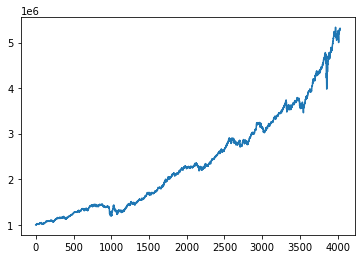

In [49]:
plt.plot(arr_port_sum[:,0])

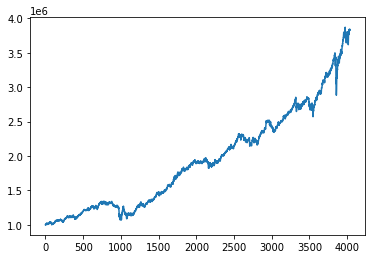

In [73]:
plt.plot(arr_port_sum[:,0])

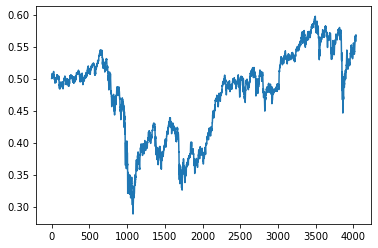

In [75]:
plt.plot(arr_port_det[:,2])

In [89]:
d.index

DatetimeIndex(['2004-11-19', '2004-11-22', '2004-11-23', '2004-11-24',
               '2004-11-26', '2004-11-29', '2004-11-30', '2004-12-01',
               '2004-12-02', '2004-12-03',
               ...
               '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19',
               '2020-11-20', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-27', '2020-11-30'],
              dtype='datetime64[ns]', name='date', length=4035, freq=None)

In [30]:
df_trades_initial, df_cash_initial, df_portfolio_sum_initial, df_portfolio_detail_initial = initialize_df(data, portfolio_weights,initial_money=10000000)
df_trades_index = data.index[list(arr_trades[:,0].astype(int))]
df_trades1 = pd.DataFrame(arr_trades[:,1:], index = df_trades_index, columns = df_trades_initial.columns)

In [29]:
df_trades

ticker              SPY                                                     \
metric          shr chg         prc   csh chg        tot shr       tot bal   
date                                                                         
2004-11-19  4258.218428  117.419998 -500000.0    4258.218428  5.000000e+05   
2004-12-01    -0.000000  119.230003       0.0 -500000.000000 -5.961500e+07   
2004-12-17     0.000000  119.440002      -0.0       0.000000  0.000000e+00   
2004-12-31    -0.000000  120.870003       0.0      -0.000000 -0.000000e+00   
2005-02-01     0.000000  118.910004      -0.0       0.000000  0.000000e+00   
...                 ...         ...       ...            ...           ...   
2020-09-01    -0.000000  352.600006       0.0      -0.000000 -0.000000e+00   
2020-09-18     0.000000  330.649994      -0.0       0.000000  0.000000e+00   
2020-10-01    -0.000000  337.040009       0.0      -0.000000 -0.000000e+00   
2020-11-02     0.000000  330.200012      -0.0       0.000000  0.000000e+00   
2020-11-24     0.000000  363.220001      -0.0       0.000000  0.000000e+00   

ticker                                TLT                             ...  \
metric     divflag rebalflag      shr chg         prc        csh chg  ...   
date                                                                  ...   
2004-11-19     0.0       0.0  4532.064246   88.260002 -400000.000000  ...   
2004-12-01     0.0       0.0 -1641.000000   86.449997  141864.444992  ...   
2004-12-17     1.0       0.0     0.000000   88.750000      -0.000000  ...   
2004-12-31     0.0       0.0    -0.000000   88.550003       0.000000  ...   
2005-02-01     0.0       0.0     0.000000   91.220001      -0.000000  ...   
...            ...       ...          ...         ...            ...  ...   
2020-09-01     0.0       0.0    -0.000000  163.860001       0.000000  ...   
2020-09-18     1.0       0.0     0.000000  163.570007      -0.000000  ...   
2020-10-01     0.0       0.0    -0.000000  163.360001       0.000000  ...   
2020-11-02     0.0       0.0     0.000000  158.580002      -0.000000  ...   
2020-11-24     0.0       1.0     0.000000  159.169998      -0.000000  ...   

ticker                                              GLD                        \
metric           tot bal divflag rebalflag      shr chg         prc   csh chg   
date                                                                            
2004-11-19  4.000000e+05     0.0       0.0  2233.139855   44.779999 -100000.0   
2004-12-01 -3.472186e+07     1.0       0.0    -0.000000   45.380001       0.0   
2004-12-17  1.259047e+07     0.0       0.0     0.000000   44.189999      -0.0   
2004-12-31 -0.000000e+00     1.0       0.0    -0.000000   43.799999       0.0   
2005-02-01  0.000000e+00     1.0       0.0     0.000000   42.099998      -0.0   
...                  ...     ...       ...          ...         ...       ...   
2020-09-01 -0.000000e+00     1.0       0.0    -0.000000  185.050003       0.0   
2020-09-18  0.000000e+00     0.0       0.0     0.000000  183.199997      -0.0   
2020-10-01 -0.000000e+00     1.0       0.0    -0.000000  178.699997       0.0   
2020-11-02  0.000000e+00     1.0       0.0     0.000000  177.910004      -0.0   
2020-11-24  0.000000e+00     0.0       1.0     0.000000  169.589996      -0.0   

ticker                                                     
metric            tot shr       tot bal divflag rebalflag  
date                                                       
2004-11-19    2233.139855  1.000000e+05     0.0       0.0  
2004-12-01 -100000.000000 -4.538000e+06     0.0       0.0  
2004-12-17       0.000000  0.000000e+00     0.0       0.0  
2004-12-31      -0.000000 -0.000000e+00     0.0       0.0  
2005-02-01       0.000000  0.000000e+00     0.0       0.0  
...                   ...           ...     ...       ...  
2020-09-01      -0.000000 -0.000000e+00     0.0       0.0  
2020-09-18       0.000000  0.000000e+00     0.0       0.0  
2020-10-01      -0.000000 -0.0000

In [55]:
trading_day_counter = 1
df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df(data, portfolio_weights,initial_money= 1000000)
arr_trades = np.append([[0]], np.array(df_trades), axis = 1)
date_start = data.index[0].date().isoformat()
arr_data_columns = data.columns.values
arr_trades_columns = df_trades.columns.values
arr_data = np.array(data)
arr_cash = np.array(df_cash)
arr_port_det = np.zeros([data.shape[0], df_portfolio_detail.shape[1]])
arr_port_sum = np.zeros([data.shape[0], df_portfolio_sum.shape[1]])
ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']

ls_trades_shr_index = [x+1 for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

arr_yesterday_prices =  arr_data[0][ls_prc_index]

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
count = 0
for row in arr_data:
    tradeflag = 0
    arr_divflag = np.zeros(len(ls_tickers))
    arr_div_cash = np.zeros(len(ls_tickers))
    arr_rebal = np.zeros(len(ls_tickers))
    arr_new_shares = np.zeros(len(ls_tickers))
    leftover_cash = 0
    arr_latest_prices = row[ls_prc_index]    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend

    if np.any(row[ls_retd_index]>0):
        arr_divflag = (row[ls_retd_index]>0).astype(int)
        arr_div_cash = arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index]
        arr_new_shares = np.floor(arr_div_cash/arr_latest_prices)
        arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.

    if 1 in arr_divflag:

        arr_div_flag_add = np.array([count]) 
        for i in range(len(ls_tickers)):
            arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        arr_divflag = np.zeros(len(ls_tickers))
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])

    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.

    if trading_day_counter % rebalance_days == 0:

        tradeflag = 1

        total_money = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]


        da = DiscreteAllocation(portfolio_weights, pd.Series(arr_latest_prices, index = ls_tickers), total_portfolio_value=total_money)
        shares, cash = da.lp_portfolio()
        arr_rebal = np.array([i for i in shares.values()])-arr_cur_shrs
        arr_trade_add = np.array([count])
        for i in range(len(ls_tickers)):
            arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        trading_day_counter=1
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])


    else:
        trading_day_counter += 1

    arr_yesterday_prices = arr_latest_prices    

    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"

    arr_new_port_det = np.array([], dtype='f8')
    arr_asset_val = (arr_cur_shrs * arr_latest_prices)
    total_value = np.sum(arr_asset_val)
    arr_actual_weights = arr_asset_val/total_value
    ls_new_port_det = []
    for i in range(len(ls_tickers)):

        ls_new_port_det = ls_new_port_det + [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]]

    arr_port_det[count] = ls_new_port_det

    arr_new_port_sum = [total_value+arr_cash[-1].item(), total_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value+arr_cash[-1].item())]

    arr_port_sum[count] = arr_new_port_sum
    count += 1


In [56]:
arr_port_sum

array([[1.00000000e+06, 9.99962419e+05, 3.75808411e+01, 3.75808411e-05],
       [1.00484883e+06, 1.00481125e+06, 3.75808411e+01, 3.73994972e-05],
       [1.00566719e+06, 1.00562961e+06, 3.75808411e+01, 3.73690633e-05],
       ...,
       [3.70978126e+06, 3.69314718e+06, 1.66340754e+04, 4.48384263e-03],
       [3.72348316e+06, 3.70684908e+06, 1.66340754e+04, 4.46734272e-03],
       [3.71008526e+06, 3.69345118e+06, 1.66340754e+04, 4.48347523e-03]])

In [62]:
arr_port_sum

array([[1.00000000e+06, 1.00000000e+06, 0.00000000e+00, 0.00000000e+00],
       [1.00484901e+06, 1.00484901e+06, 0.00000000e+00, 0.00000000e+00],
       [1.00566739e+06, 1.00566739e+06, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.70987271e+06, 3.69326030e+06, 1.66124062e+04, 4.47789116e-03],
       [3.72357468e+06, 3.70696228e+06, 1.66124062e+04, 4.46141346e-03],
       [3.71017626e+06, 3.69356386e+06, 1.66124062e+04, 4.47752479e-03]])

In [60]:
arr_port_det, arr_port_sum, arr_trades, arr_cash = calendar_threshold_rebalance_continuous(d, portfolio_weights, rebalance_days=4300)

In [61]:
arr_port_sum

array([[1.00000000e+06, 1.00000000e+06, 0.00000000e+00, 0.00000000e+00],
       [1.00484901e+06, 1.00484901e+06, 0.00000000e+00, 0.00000000e+00],
       [1.00566739e+06, 1.00566739e+06, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.70987271e+06, 3.69326030e+06, 1.66124062e+04, 4.47789116e-03],
       [3.72357468e+06, 3.70696228e+06, 1.66124062e+04, 4.46141346e-03],
       [3.71017626e+06, 3.69356386e+06, 1.66124062e+04, 4.47752479e-03]])

In [ ]:
df_portfolio

In [49]:
start_time = timeit.default_timer()
timer = []
data = d
trading_day_counter = 1
df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df(data, portfolio_weights,initial_money= 1000000)
arr_trades = np.array(df_trades)
date_start = data.index[0].date().isoformat()
arr_data_columns = data.columns.values
arr_trades_columns = df_trades.columns.values
arr_data = np.array(data)
arr_cash = np.array(df_cash)
arr_port_det = np.array(df_portfolio_detail, dtype = 'f8')
arr_port_sum = np.array(df_portfolio_sum)
ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']

ls_trades_shr_index = [x for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

arr_yesterday_prices =  arr_data[0][ls_prc_index]

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
elapsed1 = timeit.default_timer() - start_time
for row in arr_data:
    start_time6 = timeit.default_timer()
    tradeflag = 0
    arr_divflag = np.zeros(len(ls_tickers))
    arr_div_cash = np.zeros(len(ls_tickers))
    arr_rebal = np.zeros(len(ls_tickers))
    arr_new_shares = np.zeros(len(ls_tickers))
    leftover_cash = 0
    arr_latest_prices = row[ls_prc_index]
    elapsed6 = timeit.default_timer() - start_time2    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if np.any(row[ls_retd_index]>0):
        start_time2 = timeit.default_timer()
        arr_divflag = (row[ls_retd_index]>0).astype(int)
        arr_div_cash = arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index]
        arr_new_shares = np.floor(arr_div_cash/arr_latest_prices)
        arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)
        elapsed2 = timeit.default_timer() - start_time2
    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in arr_divflag:
        start_time3 = timeit.default_timer()
        arr_div_flag_add = np.array([]) 
        for i in range(len(ls_tickers)):
            arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        arr_divflag = np.zeros(len(ls_tickers))
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        elapsed3 = timeit.default_timer() - start_time3
    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if trading_day_counter % rebalance_days == 0:
        
        tradeflag = 1
        
        total_money = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
        
        start_time4 = timeit.default_timer()
        da = DiscreteAllocation(portfolio_weights, pd.Series(arr_latest_prices, index = ls_tickers), total_portfolio_value=total_money)
        shares, cash = da.lp_portfolio()
        elapsed4 = timeit.default_timer() - start_time4
        timer.append(elapsed4)
        arr_rebal = np.array([i for i in shares.values()])-arr_cur_shrs
        arr_trade_add = np.array([])
        for i in range(len(ls_tickers)):
            arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], latest_prices[i], -arr_new_shares[i] * latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        trading_day_counter=1
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        
        
    else:
        trading_day_counter += 1
    
    arr_yesterday_prices = arr_latest_prices    
        
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    arr_new_port_det = np.array([], dtype='f8')
    arr_asset_val = (arr_cur_shrs * arr_latest_prices)
    total_value = np.sum(arr_asset_val)
    arr_actual_weights = arr_asset_val/total_value
    
    for i in range(len(ls_tickers)):
        
        arr_new_port_det = np.append(arr_new_port_det, [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]])
    start_time5 = timeit.default_timer()
    arr_port_det = np.append(arr_port_det, [arr_new_port_det], axis = 0)
    
    arr_new_port_sum = np.array([total_value+arr_cash[-1].item(), total_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value+arr_cash[-1].item())])
    
    arr_port_sum = np.append(arr_port_sum, [arr_new_port_sum], axis = 0)
    elapsed5 = timeit.default_timer() - start_time5
elapsed = timeit.default_timer() - start_time

In [21]:
start_time = timeit.default_timer()
timer = []
data = d
trading_day_counter = 1
df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df(data, portfolio_weights,initial_money= 1000000)
arr_trades = np.array(df_trades)
date_start = data.index[0].date().isoformat()
arr_data_columns = data.columns.values
arr_trades_columns = df_trades.columns.values
arr_data = np.array(data)
arr_cash = np.array(df_cash)
arr_port_det = np.zeros([data.shape[0], df_portfolio_detail.shape[1]])
arr_port_sum = np.zeros([data.shape[0], df_portfolio_sum.shape[1]])
ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']

ls_trades_shr_index = [x for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

arr_yesterday_prices =  arr_data[0][ls_prc_index]

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
elapsed1 = timeit.default_timer() - start_time
count = 0
for row in arr_data:
    start_time6 = timeit.default_timer()
    tradeflag = 0
    arr_divflag = np.zeros(len(ls_tickers))
    arr_div_cash = np.zeros(len(ls_tickers))
    arr_rebal = np.zeros(len(ls_tickers))
    arr_new_shares = np.zeros(len(ls_tickers))
    leftover_cash = 0
    arr_latest_prices = row[ls_prc_index]
    elapsed6 = timeit.default_timer() - start_time2    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if np.any(row[ls_retd_index]>0):
        start_time2 = timeit.default_timer()
        arr_divflag = (row[ls_retd_index]>0).astype(int)
        arr_div_cash = arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index]
        arr_new_shares = np.floor(arr_div_cash/arr_latest_prices)
        arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)
        elapsed2 = timeit.default_timer() - start_time2
    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in arr_divflag:
        start_time3 = timeit.default_timer()
        arr_div_flag_add = np.array([]) 
        for i in range(len(ls_tickers)):
            arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        arr_divflag = np.zeros(len(ls_tickers))
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        elapsed3 = timeit.default_timer() - start_time3
    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if trading_day_counter % rebalance_days == 0:
        
        tradeflag = 1
        
        total_money = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
        
        start_time4 = timeit.default_timer()
        da = DiscreteAllocation(portfolio_weights, pd.Series(arr_latest_prices, index = ls_tickers), total_portfolio_value=total_money)
        shares, cash = da.lp_portfolio()
        elapsed4 = timeit.default_timer() - start_time4
        timer.append(elapsed4)
        arr_rebal = np.array([i for i in shares.values()])-arr_cur_shrs
        arr_trade_add = np.array([])
        for i in range(len(ls_tickers)):
            arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], latest_prices[i], -arr_new_shares[i] * latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        trading_day_counter=1
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        
        
    else:
        trading_day_counter += 1
    
    arr_yesterday_prices = arr_latest_prices    
        
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    arr_new_port_det = np.array([], dtype='f8')
    arr_asset_val = (arr_cur_shrs * arr_latest_prices)
    total_value = np.sum(arr_asset_val)
    arr_actual_weights = arr_asset_val/total_value
    ls_new_port_det = []
    for i in range(len(ls_tickers)):
        
        ls_new_port_det = ls_new_port_det + [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]]
    start_time5 = timeit.default_timer()
    arr_port_det[count] = ls_new_port_det
    
    arr_new_port_sum = [total_value+arr_cash[-1].item(), total_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value+arr_cash[-1].item())]
    
    arr_port_sum[count] = arr_new_port_sum
    count += 1
    elapsed5 = timeit.default_timer() - start_time5
elapsed = timeit.default_timer() - start_time

NameError: name 'start_time2' is not defined

In [29]:
start_time = timeit.default_timer()
trading_day_counter = 1
df_trades, df_cash, df_portfolio_sum, df_portfolio_detail = initialize_df_continuous(data, portfolio_weights,initial_money= 1000000)
arr_trades = np.array(df_trades)
date_start = data.index[0].date().isoformat()
arr_data_columns = data.columns.values
arr_trades_columns = df_trades.columns.values
arr_data = np.array(data)
arr_cash = np.array(df_cash)
arr_port_det = np.zeros([data.shape[0], df_portfolio_detail.shape[1]])
arr_port_sum = np.zeros([data.shape[0], df_portfolio_sum.shape[1]])
ls_tickers = list(set([y[0] for x, y in enumerate(arr_data_columns)]))
ls_prc_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'prc']
ls_ret_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'ret']
ls_retx_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retx']
ls_retd_index = [x for x, y in enumerate(arr_data_columns) if y[1] == 'retd']
arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])
ls_trades_shr_index = [x for x, y in enumerate(arr_trades_columns) if y[1] == 'tot shr']

arr_yesterday_prices =  arr_data[0][ls_prc_index]

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
elapsed1 = timeit.default_timer() - start_time
count = 0
for row in arr_data:
    start_time6 = timeit.default_timer()
    tradeflag = 0
    arr_divflag = np.zeros(len(ls_tickers))
    arr_div_cash = np.zeros(len(ls_tickers))
    arr_rebal = np.zeros(len(ls_tickers))
    arr_new_shares = np.zeros(len(ls_tickers))
    leftover_cash = 0
    arr_latest_prices = row[ls_prc_index]
    elapsed6 = timeit.default_timer() - start_time2    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if np.any(row[ls_retd_index]>0):
        start_time2 = timeit.default_timer()
        arr_divflag = (row[ls_retd_index]>0).astype(int)
        arr_div_cash = arr_yesterday_prices*arr_trades[-1][ls_trades_shr_index]*row[ls_retd_index]
        arr_new_shares = np.floor(arr_div_cash/arr_latest_prices)
        arr_leftover_cash = arr_div_cash-(arr_new_shares*arr_latest_prices)
        elapsed2 = timeit.default_timer() - start_time2
    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in arr_divflag:
        start_time3 = timeit.default_timer()
        arr_div_flag_add = np.array([]) 
        for i in range(len(ls_tickers)):
            arr_div_flag_add = np.append(arr_div_flag_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_div_flag_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        arr_divflag = np.zeros(len(ls_tickers))
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        elapsed3 = timeit.default_timer() - start_time3
    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if trading_day_counter % rebalance_days == 0:
        
        tradeflag = 1
        
        total_money = np.matmul(np.array(arr_latest_prices),arr_cur_shrs)+arr_cash[-1]
        
        start_time4 = timeit.default_timer()
        arr_shares = (total_money*arr_portfolio_weights)/arr_latest_prices
        elapsed4 = timeit.default_timer() - start_time4
        timer.append(elapsed4)
        arr_rebal = arr_shares-arr_cur_shrs
        arr_trade_add = np.array([])
        for i in range(len(ls_tickers)):
            arr_trade_add = np.append(arr_trade_add, np.array([arr_new_shares[i], arr_latest_prices[i], -arr_new_shares[i] * arr_latest_prices[i], arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i], (arr_trades[-1][ls_trades_shr_index[i]]+arr_new_shares[i])*arr_latest_prices[i], arr_divflag[i], tradeflag]))
        arr_trades = np.append(arr_trades,[arr_trade_add], axis = 0)
        arr_cash = np.append(arr_cash, [np.array(arr_cash[-1]+np.sum(arr_leftover_cash))], axis=0)
        trading_day_counter=1
        arr_cur_shrs = np.array(arr_trades[-1][ls_trades_shr_index])
        
        
    else:
        trading_day_counter += 1
    
    arr_yesterday_prices = arr_latest_prices    
        
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    arr_new_port_det = np.array([], dtype='f8')
    arr_asset_val = (arr_cur_shrs * arr_latest_prices)
    total_value = np.sum(arr_asset_val)
    arr_actual_weights = arr_asset_val/total_value
    ls_new_port_det = []
    for i in range(len(ls_tickers)):
        
        ls_new_port_det = ls_new_port_det + [arr_latest_prices[i], row[ls_ret_index[i]], arr_actual_weights[i], arr_cur_shrs[i], arr_asset_val[i]]
    start_time5 = timeit.default_timer()
    arr_port_det[count] = ls_new_port_det
    
    arr_new_port_sum = [total_value+arr_cash[-1].item(), total_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value+arr_cash[-1].item())]
    
    arr_port_sum[count] = arr_new_port_sum
    count += 1
    elapsed5 = timeit.default_timer() - start_time5
elapsed = timeit.default_timer() - start_time

NameError: name 'start_time2' is not defined

In [42]:
arr_port_det

array([[1.17419998e+02, 9.88883276e-01, 5.00000000e-01, ...,
        1.00000000e-01, 2.23313986e+03, 1.00000000e+05],
       [1.17980003e+02, 1.00476925e+00, 4.99960313e-01, ...,
        9.98952454e-02, 2.23313986e+03, 1.00379638e+05],
       [1.18160004e+02, 1.00152568e+00, 5.00315622e-01, ...,
        9.93698410e-02, 2.23313986e+03, 9.99330085e+04],
       ...,
       [3.62660004e+02, 9.98458241e-01, 5.72302395e-01, ...,
        1.02494678e-01, 2.23313986e+03, 3.78539525e+05],
       [3.63670013e+02, 1.00278500e+00, 5.71774978e-01, ...,
        1.01079669e-01, 2.23313986e+03, 3.74698521e+05],
       [3.62059998e+02, 9.95572866e-01, 5.71308587e-01, ...,
        1.00769184e-01, 2.23313986e+03, 3.72197416e+05]])

In [44]:
arr_port_sum[-1]

array([3.71368904e+06, 3.69356386e+06, 2.01251774e+04, 5.41918755e-03])

In [52]:
arr_port_sum

array([[1000000.0, 999962.4191589355, 37.580841064453125,
        3.7580841064453125e-05],
       [1004848.832370758, 1004811.2515296936, 37.580841064453125,
        3.7399497171915865e-05],
       [1005667.194732666, 1005629.6138916016, 37.580841064453125,
        3.736906330572227e-05],
       ...,
       [3709781.2590085836, 3693147.1836395264, 16634.075369057213,
        0.004483842633218372],
       [3723483.1578733297, 3706849.0825042725, 16634.075369057213,
        0.004467342717499433],
       [3710085.2593900533, 3693451.184020996, 16634.075369057213,
        0.004483475231992888]], dtype=object)

In [45]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+06,9.999624e+05,37.580841,0.000038
2004-11-22,1.004849e+06,1.004811e+06,37.580841,0.000037
2004-11-23,1.005667e+06,1.005630e+06,37.580841,0.000037
2004-11-24,1.007529e+06,1.007492e+06,37.580841,0.000037
2004-11-26,1.005011e+06,1.004973e+06,37.580841,0.000037
...,...,...,...,...
2020-11-23,4.188256e+06,4.187547e+06,708.882467,0.000169
2020-11-24,4.200630e+06,4.200411e+06,219.034139,0.000052
2020-11-25,4.192021e+06,4.191802e+06,219.034139,0.000052


In [46]:

start_time = timeit.default_timer()
rebalance_days = 4100
trading_day_counter = 1
df_trades = df_trades_initial
portfolio_detail = df_portfolio_detail_initial
portfolio_sum = df_portfolio_sum_initial
df_cash = df_cash_initial
yesterday_prices =  {'SPY': d.loc[date_start]['SPY']['prc'], 'TLT': d.loc[date_start]['TLT']['prc'], \
          'GLD': d.loc[date_start]['GLD']['prc']}
portfolio_weights = {'SPY':0.5, 'TLT': 0.4, "GLD": 0.1}
#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    s_divflag, t_divflag, g_divflag = (0,0,0)
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    latest_prices = {'SPY': row['SPY']['prc'], 'TLT': row['TLT']['prc'], \
          'GLD': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0
    
    
    #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if row['SPY']['retd'] > 0:
        s_divflag=1
        spy_div_cash = yesterday_prices['SPY']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/latest_prices['SPY'])
        leftover_cash = spy_div_cash-(new_spy_shares*latest_prices['SPY'])
        
    if row['TLT']['retd'] > 0:
        t_divflag = 1
        tlt_div_cash = yesterday_prices['TLT']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/latest_prices['TLT'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*latest_prices['TLT'])+leftover_cash
    
    if row['GLD']['retd'] > 0:
        g_divflag=1
        gld_div_cash = yesterday_prices['GLD']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/latest_prices['GLD'])
        leftover_cash = gld_div_cash-(new_gld_shares*latest_prices['GLD'])+leftover_cash

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in [s_divflag, t_divflag, g_divflag]:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['SPY'], -new_spy_shares * latest_prices['SPY'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['SPY'], s_divflag, tradeflag,
                        new_tlt_shares, latest_prices['TLT'], -new_tlt_shares * latest_prices['TLT'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['TLT'], t_divflag, tradeflag,
                        new_gld_shares, latest_prices['GLD'], -new_gld_shares * latest_prices['GLD'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['GLD'], g_divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0
    
    #Checks to see if rebalancing should occur on this day based on the trade counter chosen. This sells all the shares
    #and reblances using the original weights and the total value available. The share amount before rebalancing is then
    #subtracted to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if trading_day_counter % rebalance_days == 0:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['SPY']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['TLT']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['GLD']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['SPY'], -rebal_spy*latest_prices['SPY'],shares['SPY'], shares['SPY']*latest_prices['SPY'], divflag, tradeflag,
                        rebal_tlt, latest_prices['TLT'], -rebal_tlt*latest_prices['TLT'], shares['TLT'], shares['TLT']*latest_prices['TLT'], divflag, tradeflag,
                        rebal_gld, latest_prices['GLD'], -rebal_gld*latest_prices['GLD'], shares['GLD'], shares['GLD']*latest_prices['GLD'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1
    yesterday_prices = latest_prices    
        
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    share_dic = {'SPY':df_trades['SPY']['tot shr'].iloc[-1],
                 'TLT':df_trades['TLT']['tot shr'].iloc[-1],
                 'GLD':df_trades['GLD']['tot shr'].iloc[-1]}
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    
    new_port_det = np.array([[latest_prices['SPY'], row["SPY"]['ret'], actual_weights["SPY"], share_dic['SPY'], tic_vals['SPY'],
                    latest_prices['TLT'], row["TLT"]['ret'], actual_weights["TLT"], share_dic['TLT'], tic_vals['TLT'],
                    latest_prices['GLD'], row["GLD"]['ret'], actual_weights["GLD"], share_dic['GLD'], tic_vals['GLD']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))
    
    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])
    
    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))

portfolio_detail.index = d.index
portfolio_sum.index = d.index
elapsed = timeit.default_timer() - start_time

In [31]:
threshold = .1
df_trades = df_trades_initial
df_cash = df_cash_initial

portfolio_detail = df_portfolio_detail_initial
portfolio_sum = df_portfolio_sum_initial
yesterday_prices =  {'SPY': d.loc[date_start]['SPY']['prc'], 'TLT': d.loc[date_start]['TLT']['prc'], \
          'GLD': d.loc[date_start]['GLD']['prc']}

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

for index, row in d.iterrows():
    tradeflag = 0
    s_divflag, t_divflag, g_divflag = (0,0,0)
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    leftover_cash = 0
    
    latest_prices = {'SPY': row['SPY']['prc'], 'TLT': row['TLT']['prc'], \
          'GLD': row['GLD']['prc']}
    new_spy_shares = 0
    new_gld_shares = 0
    new_tlt_shares = 0
    
        #Checks to see if there are any dividend payouts, and if so, calculates the number of shares that are purchased as part of 
    #the reinvestment and the leftover cash if a full share cannot be purchased. Dividend payouts are reinvested into the asset
    #that payed the dividend
    
    if row['SPY']['retd'] > 0:
        s_divflag=1
        spy_div_cash = yesterday_prices['SPY']*df_trades['SPY']['tot shr'].iloc[-1]*row['SPY']['retd']
        new_spy_shares = int(spy_div_cash/latest_prices['SPY'])
        leftover_cash = spy_div_cash-(new_spy_shares*latest_prices['SPY'])
        
    if row['TLT']['retd'] > 0:
        t_divflag = 1
        tlt_div_cash = yesterday_prices['TLT']*df_trades['TLT']['tot shr'].iloc[-1]*row['TLT']['retd']
        new_tlt_shares = int(tlt_div_cash/latest_prices['TLT'])
        leftover_cash = tlt_div_cash-(new_tlt_shares*latest_prices['TLT'])+leftover_cash
    
    if row['GLD']['retd'] > 0:
        g_divflag=1
        gld_div_cash = yesterday_prices['GLD']*df_trades['GLD']['tot shr'].iloc[-1]*row['GLD']['retd']
        new_gld_shares = int(gld_div_cash/latest_prices['GLD'])
        leftover_cash = gld_div_cash-(new_gld_shares*latest_prices['GLD'])+leftover_cash

    #Executes the actual trade, recording it in the df_trades dataframe and updates the df_cash dataframe. This is done before
    #rebalancing incase a) rebalancing happens on the same day in the case of calendar rebalancing, or b) the dividend payout
    #puts the asset over the threshold.
    
    if 1 in [s_divflag, t_divflag, g_divflag]:
        div_trade_add = pd.DataFrame([[new_spy_shares, latest_prices['SPY'], -new_spy_shares * latest_prices['SPY'],df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares, (df_trades['SPY']['tot shr'].iloc[-1]+new_spy_shares)*latest_prices['SPY'], s_divflag, tradeflag,
                        new_tlt_shares, latest_prices['TLT'], -new_tlt_shares * latest_prices['TLT'],df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares, (df_trades['TLT']['tot shr'].iloc[-1]+new_tlt_shares)*latest_prices['TLT'], t_divflag, tradeflag,
                        new_gld_shares, latest_prices['GLD'], -new_gld_shares * latest_prices['GLD'],df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares, (df_trades['GLD']['tot shr'].iloc[-1]+new_gld_shares)*latest_prices['GLD'], g_divflag, tradeflag]], index = [index], columns = df_trades.columns) 
        df_trades = df_trades.append(div_trade_add)
        df_cash = df_cash.append(pd.DataFrame(df_cash['cash'].iloc[-1]+leftover_cash,columns = ['cash'], 
                         index = [row.name]))
        divflag=0
    
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    dev_weights = {k:abs((actual_weights[k]/portfolio_weights[k])-1) for k in actual_weights}
    
    #Checks to see if rebalancing should occur due to an asset passing the threshold. The % deviation is calculated by: 
    #
    #                       |[Actual % of portfolio] / [target % of portfolio] - 1|
    #
    #If this absolute value is greater than the threshold, rebalancing occurs. This sells all the shares and reblances 
    #using the original weights and the total value available. The share amount before rebalancing is then subtracted 
    #to find the total change in shares for each asset. The df_trades and df_cash dataframes are then updated.
    
    if max(dev_weights[k] for k in actual_weights) > threshold:
        tradeflag = 1
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array([df_trades['SPY']['tot shr'].iloc[-1], df_trades['TLT']['tot shr'].iloc[-1],df_trades['GLD']['tot shr'].iloc[-1]])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_cash['cash'].iloc[-1]
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['SPY']-df_trades['SPY']['tot shr'].iloc[-1]
        rebal_tlt = shares['TLT']-df_trades['TLT']['tot shr'].iloc[-1]
        rebal_gld = shares['GLD']-df_trades['GLD']['tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['SPY'], -rebal_spy*latest_prices['SPY'],shares['SPY'], shares['SPY']*latest_prices['SPY'], divflag, tradeflag,
                        rebal_tlt, latest_prices['TLT'], -rebal_tlt*latest_prices['TLT'], shares['TLT'], shares['TLT']*latest_prices['TLT'], divflag, tradeflag,
                        rebal_gld, latest_prices['GLD'], -rebal_gld*latest_prices['GLD'], shares['GLD'], shares['GLD']*latest_prices['GLD'], divflag, tradeflag]], 
                        index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        df_cash = df_cash.append(pd.DataFrame(cash,columns = ['cash'],index = [row.name]))
        trading_day_counter=1
    else:
        trading_day_counter += 1
        yesterday_prices = latest_prices 
    
    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    
    share_dic = {'SPY':df_trades['SPY']['tot shr'].iloc[-1],
                 'TLT':df_trades['TLT']['tot shr'].iloc[-1],
                 'GLD':df_trades['GLD']['tot shr'].iloc[-1]}
    
    tic_vals = {k: share_dic[k]*latest_prices[k] for k in share_dic}
    total_value = sum(share_dic[k]*latest_prices[k] for k in share_dic)
    actual_weights = {k:tic_vals[k]/total_value for k in tic_vals}
    
    new_port_det = np.array([[latest_prices['SPY'], row["SPY"]['ret'], actual_weights["SPY"], share_dic['SPY'], tic_vals['SPY'],
                    latest_prices['TLT'], row["TLT"]['ret'], actual_weights["TLT"], share_dic['TLT'], tic_vals['TLT'],
                    latest_prices['GLD'], row["GLD"]['ret'], actual_weights["GLD"], share_dic['GLD'], tic_vals['GLD']]])
    portfolio_detail = portfolio_detail.append(pd.DataFrame(new_port_det,columns = portfolio_detail.columns))
    
    new_port_sum = np.array([[total_value+df_cash.iloc[-1][0], total_value, df_cash.iloc[-1][0], df_cash.iloc[-1][0]/(total_value+df_cash.iloc[-1][0])]])
    
    portfolio_sum = portfolio_sum.append(pd.DataFrame(new_port_sum, columns = portfolio_sum.columns))

portfolio_detail.index = d.index
portfolio_sum.index = d.index

NameError: name 'share_dic' is not defined

In [47]:
portfolio_detail

ticker             SPY                                                   TLT  \
metric           price    return    weight  shares         value       price   
date                                                                           
2004-11-19  117.419998  0.988883  0.499993  4258.0  4.999744e+05   88.260002   
2004-11-22  117.980003  1.004769  0.499953  4258.0  5.023589e+05   88.720001   
2004-11-23  118.160004  1.001526  0.500309  4258.0  5.031253e+05   88.830002   
2004-11-24  118.440002  1.002370  0.500567  4258.0  5.043175e+05   88.830002   
2004-11-26  118.339996  0.999156  0.501398  4258.0  5.038917e+05   88.250000   
...                ...       ...       ...     ...           ...         ...   
2020-11-23  357.459991  1.005994  0.565380  5828.0  2.083277e+06  160.770004   
2020-11-24  363.220001  1.016114  0.572074  5828.0  2.116846e+06  159.169998   
2020-11-25  362.660004  0.998458  0.572298  5828.0  2.113583e+06  158.679993   
2020-11-27  363.670013  1.002785  0.571771  5828.0  2.119469e+06  160.220001   
2020-11-30  362.059998  0.995573  0.571305  5828.0  2.110086e+06  160.020004   

ticker                                                       GLD            \
metric        return    weight  shares         value       price    return   
date                                                                         
2004-11-19  0.992020  0.400009  4532.0  3.999943e+05   44.779999  1.009013   
2004-11-22  1.005212  0.400154  4532.0  4.020790e+05   44.950001  1.003796   
2004-11-23  1.001240  0.400324  4532.0  4.025776e+05   44.750000  0.995551   
2004-11-24  1.000000  0.399584  4532.0  4.025776e+05   45.049999  1.006704   
2004-11-26  0.993471  0.397970  4532.0  3.999490e+05   45.290001  1.005327   
...              ...       ...     ...           ...         ...       ...   
2020-11-23  0.995418  0.330246  7569.0  1.216868e+06  172.229996  0.980306   
2020-11-24  0.990048  0.325584  7569.0  1.204758e+06  169.589996  0.984672   
2020-11-25  0.996921  0.325210  7569.0  1.201049e+06  169.509995  0.999528   
2020-11-27  1.009705  0.327153  7569.0  1.212705e+06  167.789993  0.989853   
2020-11-30  0.998752  0.327929  7569.0  1.211191e+06  166.669998  0.993325   

ticker                                       
metric        weight  shares          value  
date                                         
2004-11-19  0.099997  2233.0   99993.737274  
2004-11-22  0.099893  2233.0  100373.351704  
2004-11-23  0.099367  2233.0   99926.750000  
2004-11-24  0.099849  2233.0  100596.648296  
2004-11-26  0.100632  2233.0  101132.572044  
...              ...     ...            ...  
2020-11-23  0.104374  2233.0  384589.580460  
2020-11-24  0.102342  2233.0  378694.461823  
2020-11-25  0.102491  2233.0  378515.817734  
2020-11-27  0.101076  2233.0  374675.055008  
2020-11-30  0.100766  2233.0  372174.105911  

[4035 rows x 15 columns]

In [48]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+06,9.999624e+05,37.580841,0.000038
2004-11-22,1.004849e+06,1.004811e+06,37.580841,0.000037
2004-11-23,1.005667e+06,1.005630e+06,37.580841,0.000037
2004-11-24,1.007529e+06,1.007492e+06,37.580841,0.000037
2004-11-26,1.005011e+06,1.004973e+06,37.580841,0.000037
...,...,...,...,...
2020-11-23,3.701369e+06,3.684735e+06,16634.075369,0.004494
2020-11-24,3.716932e+06,3.700298e+06,16634.075369,0.004475
2020-11-25,3.709781e+06,3.693147e+06,16634.075369,0.004484


In [16]:
df_trades

ticker                   SPY                                                   \
metric               shr chg         prc       csh chg  tot shr       tot bal   
2004-11-19           42582.0  117.419998 -4.999978e+06  42582.0  4.999978e+06   
2004-11-19 00:00:00      0.0  117.419998 -0.000000e+00  42582.0  4.999978e+06   
2004-12-01 00:00:00      0.0  119.230003  0.000000e+00  42582.0  5.077052e+06   
2004-12-17 00:00:00    200.0  119.440002 -2.388800e+04  42782.0  5.109882e+06   
2004-12-31 00:00:00      0.0  120.870003  0.000000e+00  42782.0  5.171060e+06   
...                      ...         ...           ...      ...           ...   
2020-09-01 00:00:00      0.0  352.600006  0.000000e+00  62698.0  2.210732e+07   
2020-09-18 00:00:00    250.0  330.649994 -8.266250e+04  62948.0  2.081376e+07   
2020-10-01 00:00:00      0.0  337.040009  0.000000e+00  62948.0  2.121599e+07   
2020-11-02 00:00:00      0.0  330.200012  0.000000e+00  62948.0  2.078543e+07   
2020-11-23 00:00:00  -4133.0  357.459991  1.477382e+06  58815.0  2.102401e+07   

ticker                                     TLT                            ...  \
metric              divflag rebalflag  shr chg         prc       csh chg  ...   
2004-11-19              0.0       0.0  45321.0   88.260002 -4.000032e+06  ...   
2004-11-19 00:00:00     0.0       1.0      0.0   88.260002 -0.000000e+00  ...   
2004-12-01 00:00:00     1.0       0.0    184.0   86.449997 -1.590680e+04  ...   
2004-12-17 00:00:00     1.0       0.0      0.0   88.750000  0.000000e+00  ...   
2004-12-31 00:00:00     1.0       0.0    172.0   88.550003 -1.523060e+04  ...   
...                     ...       ...      ...         ...           ...  ...   
2020-09-01 00:00:00     1.0       0.0    110.0  163.860001 -1.802460e+04  ...   
2020-09-18 00:00:00     1.0       0.0      0.0  163.570007  0.000000e+00  ...   
2020-10-01 00:00:00     1.0       0.0    101.0  163.360001 -1.649936e+04  ...   
2020-11-02 00:00:00     1.0       0.0    105.0  158.580002 -1.665090e+04  ...   
2020-11-23 00:00:00     0.0       1.0   6352.0  160.770004 -1.021211e+06  ...   

ticker                                                   GLD              \
metric                    tot bal divflag rebalflag  shr chg         prc   
2004-11-19           4.000032e+06     0.0       0.0  22331.0   44.779999   
2004-11-19 00:00:00  4.000032e+06     0.0       1.0      0.0   44.779999   
2004-12-01 00:00:00  3.933907e+06     1.0       0.0      0.0   45.380001   
2004-12-17 00:00:00  4.038569e+06     1.0       0.0      0.0   44.189999   
2004-12-31 00:00:00  4.044698e+06     1.0       0.0      0.0   43.799999   
...                           ...     ...       ...      ...         ...   
2020-09-01 00:00:00  1.606795e+07     1.0       0.0      0.0  185.050003   
2020-09-18 00:00:00  1.603951e+07     1.0       0.0      0.0  183.199997   
2020-10-01 00:00:00  1.603542e+07     1.0       0.0      0.0  178.699997   
2020-11-02 00:00:00  1.558286e+07     1.0       0.0      0.0  177.910004   
2020-11-23 00:00:00  1.681928e+07     0.0       1.0   2650.0  172.229996   

ticker                                                                       
metric                     csh chg  tot shr       tot bal divflag rebalflag  
2004-11-19          -999982.152740  22331.0  9.999822e+05     0.0       0.0  
2004-11-19 00:00:00      -0.000000  22331.0  9.999822e+05     0.0       1.0  
2004-12-01 00:00:00       0.000000  22331.0  1.013381e+06     1.0       0.0  
2004-12-17 00:00:00       0.000000  22331.0  9.868069e+05     1.0       0.0  
2004-12-31 00:00:00       0.000000  22331.0  9.780978e+05     1.0       0.0  
...                            ...      ...           ...     ...       ...  
2020-09-01 00:00:00       0.000000  21764.0  4.027428e+06     1.0       0.0  
2020-09-18 00:00:00       0.000000  21764.0  3.987165e+06     1.0       0.0  
2020-10-01 00:00:00       0.000000  21764.0  3.889227e+06     1.0       0.0  
2020-11-02 00:00:00       0.000000  21764.0  

## Analysis of Returns

This is done for Threshold Rebalancing

### Compaison of underlying assets

In [17]:
portfolio_cumret = portfolio_sum.total_value/money
spy_cum_ret = d.SPY.ret.cumprod()
gld_cum_ret = d.GLD.ret.cumprod()
tlt_cum_ret = d.TLT.ret.cumprod()

In [50]:
spy_cum_ret[-1]+gld_cum_ret[-1]+tlt_cum_ret[-1]

3.7267236186735504

In [49]:
gld_cum_ret[-1]

0.37219742589497307

In [46]:
spy_ret = np.array(d.SPY.ret[1:]-1)*.5
gld_ret = np.array(d.GLD.ret[1:]-1)*.1
tlt_ret = np.array(d.TLT.ret[1:]-1)*.4
port_ret = spy_ret+gld_ret+tlt_ret
(port_ret+1).cumprod()

array([1.00484901, 1.0056668 , 1.00753253, ..., 4.38068135, 4.39934244,
       4.38447103])

In [21]:
spy_ret = np.array(d.SPY.ret-1)

(spy_ret[1:3]+1).cumprod()*.5

array([0.50238462, 0.50315111])

In [45]:
((spy_ret[1:]*.5)+1).cumprod()+((gld_ret[1:]*.5)+1).cumprod()

ValueError: operands could not be broadcast together with shapes (4034,) (4033,) 

In [140]:
cum_ret = pd.DataFrame(np.array(port_ret).T, columns = ['portfolio'], index = portfolio_detail.index)

In [24]:
spy_cum_ret = d.SPY.ret[1:].cumprod()*.5
gld_cum_ret = d.GLD.ret[1:].cumprod()*.1
tlt_cum_ret = d.TLT.ret[1:].cumprod()*.4

print(spy_cum_ret+gld_cum_ret+tlt_cum_ret)

date
2004-11-22    1.004849
2004-11-23    1.005667
2004-11-24    1.007530
2004-11-26    1.005011
2004-11-29    0.998740
                ...   
2020-11-23    3.717932
2020-11-24    3.733508
2020-11-25    3.726275
2020-11-27    3.740206
2020-11-30    3.726724
Name: ret, Length: 4034, dtype: float64


In [53]:
spy_cum_ret = ((d.SPY.ret[1:]-1)*.5+1).cumprod()
gld_cum_ret = ((d.GLD.ret[1:]-1)*.1+1).cumprod()
tlt_cum_ret = ((d.TLT.ret[1:]-1)*.4+1).cumprod()

print(spy_cum_ret,gld_cum_ret,tlt_cum_ret)

date
2004-11-22    1.002385
2004-11-23    1.003149
2004-11-24    1.004338
2004-11-26    1.003914
2004-11-29    1.001666
                ...   
2020-11-23    2.211673
2020-11-24    2.229492
2020-11-25    2.227773
2020-11-27    2.230875
2020-11-30    2.225937
Name: ret, Length: 4034, dtype: float64 date
2004-11-22    1.000380
2004-11-23    0.999935
2004-11-24    1.000605
2004-11-26    1.001138
2004-11-29    1.001381
                ...   
2020-11-23    1.172031
2020-11-24    1.170234
2020-11-25    1.170179
2020-11-27    1.168992
2020-11-30    1.168211
Name: ret, Length: 4034, dtype: float64 date
2004-11-22    1.002085
2004-11-23    1.002582
2004-11-24    1.002582
2004-11-26    0.999963
2004-11-29    0.995703
                ...   
2020-11-23    1.632796
2020-11-24    1.626296
2020-11-25    1.624293
2020-11-27    1.630599
2020-11-30    1.629785
Name: ret, Length: 4034, dtype: float64


In [197]:
portfolio_weights = np.array([.5,.4,.1])
StockReturns = pd.DataFrame(np.array([d.SPY.ret[1:]-1, d.GLD.ret[1:]-1, d.TLT.ret[1:]-1]).T)
port_ret = StockReturns.mul(portfolio_weights, axis=1).sum(axis=1)

In [37]:
((d.SPY.ret[1:]).cumprod()*.5)

date
2004-11-22    0.502385
2004-11-23    0.503151
2004-11-24    0.504343
2004-11-26    0.503918
2004-11-29    0.501661
                ...   
2020-11-23    2.096399
2020-11-24    2.130180
2020-11-25    2.126896
2020-11-27    2.132819
2020-11-30    2.123377
Name: ret, Length: 4034, dtype: float64

In [195]:
np.array([d.SPY.ret[1:]-1, d.GLD.ret[1:]-1, d.TLT.ret[1:]-1]).

array([[ 0.00476925,  0.00152568,  0.00236966, ..., -0.00154176,
         0.002785  , -0.00442713],
       [ 0.00379638, -0.00444941,  0.00670389, ..., -0.00047174,
        -0.0101469 , -0.00667498],
       [ 0.00521186,  0.00123986,  0.        , ..., -0.0030785 ,
         0.00970512, -0.00124826]])

In [145]:
port = np.array([d.SPY.ret,d.TLT.ret, d.GLD.ret]).T

In [146]:
port

array([[0.98888328, 0.99201979, 1.00901302],
       [1.00476925, 1.00521186, 1.00379638],
       [1.00152568, 1.00123986, 0.99555059],
       ...,
       [0.99845824, 0.9969215 , 0.99952826],
       [1.002785  , 1.00970512, 0.9898531 ],
       [0.99557287, 0.99875174, 0.99332502]])

### Comparison between an untouched portfolio and a rebalanced portfolio

In [147]:
portfolio_weights = np.array([.5, .4, .1])

In [148]:
port_ret = np.matmul(port, portfolio_weights)

In [149]:
port_ret.T.shape

(4035,)

In [150]:
df_port_ret = pd.DataFrame([port_ret, cum_ret['portfolio']]).T

In [151]:
df_port_ret.columns = ['untouched_port', 'rebal_port']

In [152]:
df_port_ret['untouched_port'] = df_port_ret['untouched_port'].cumprod()

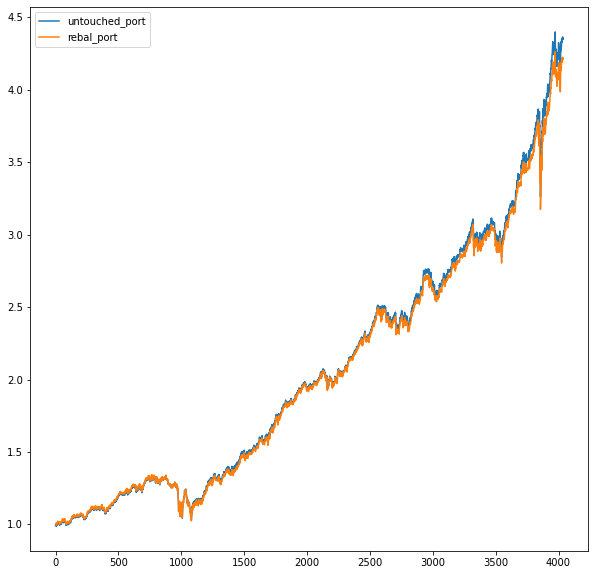

In [30]:
df_port_ret.plot(figsize = (10,10))

In [153]:
df_port_ret

,untouched_port,rebal_port
0,0.992151,0.992151
1,0.996962,1.004849
2,0.997773,1.000814
3,0.999624,1.001855
4,0.997124,0.997499
...,...,...
4030,4.344175,0.999195
4031,4.355223,1.002543
4032,4.346297,0.997951
4033,4.364811,1.004260


In [64]:
portfolio_sum

,total_value,asset_value,cash,cash_pct
date,,,,
2004-11-19,1.000000e+06,9.999624e+05,37.580841,0.000038
2004-11-22,1.004849e+06,1.004811e+06,37.580841,0.000037
2004-11-23,1.005667e+06,1.005630e+06,37.580841,0.000037
2004-11-24,1.007529e+06,1.007492e+06,37.580841,0.000037
2004-11-26,1.005011e+06,1.004973e+06,37.580841,0.000037
...,...,...,...,...
2020-11-23,3.701369e+06,3.684735e+06,16634.075369,0.004494
2020-11-24,3.716932e+06,3.700298e+06,16634.075369,0.004475
2020-11-25,3.709781e+06,3.693147e+06,16634.075369,0.004484


In [155]:
df_trades

ticker                      SPY                                        \
metric                  shr chg         prc       csh chg     tot shr   
2004-11-19           42582183.0  117.419998 -5.000000e+09  42582183.0   
2004-12-01 00:00:00         0.0  119.230003  0.000000e+00  42582183.0   
2004-12-17 00:00:00    202461.0  119.440002 -2.418194e+07  42784644.0   
2004-12-31 00:00:00         0.0  120.870003  0.000000e+00  42784644.0   
2005-02-01 00:00:00         0.0  118.910004  0.000000e+00  42784644.0   
...                         ...         ...           ...         ...   
2020-08-03 00:00:00         0.0  328.790009  0.000000e+00  58410485.0   
2020-09-01 00:00:00         0.0  352.600006  0.000000e+00  58410485.0   
2020-09-18 00:00:00    236578.0  330.649994 -7.822451e+07  58647063.0   
2020-10-01 00:00:00         0.0  337.040009  0.000000e+00  58647063.0   
2020-11-02 00:00:00         0.0  330.200012  0.000000e+00  58647063.0   

ticker                                                      TLT              \
metric                    tot bal divflag rebalflag     shr chg         prc   
2004-11-19           5.000000e+09     0.0       0.0  45320643.0   88.260002   
2004-12-01 00:00:00  5.077074e+09     0.0       0.0    185886.0   86.449997   
2004-12-17 00:00:00  5.110198e+09     1.0       0.0         0.0   88.750000   
2004-12-31 00:00:00  5.171380e+09     0.0       0.0    172204.0   88.550003   
2005-02-01 00:00:00  5.087522e+09     0.0       0.0    172562.0   91.220001   
...                           ...     ...       ...         ...         ...   
2020-08-03 00:00:00  1.920478e+10     0.0       0.0     85704.0  169.949997   
2020-09-01 00:00:00  2.059554e+10     0.0       0.0     85610.0  163.860001   
2020-09-18 00:00:00  1.939165e+10     1.0       0.0         0.0  163.570007   
2020-10-01 00:00:00  1.976641e+10     0.0       0.0     79454.0  163.360001   
2020-11-02 00:00:00  1.936526e+10     0.0       0.0     82123.0  158.580002   

ticker                             ...                                  \
metric                    csh chg  ...       tot bal divflag rebalflag   
2004-11-19          -4.000000e+09  ...  4.000000e+09     0.0       0.0   
2004-12-01 00:00:00 -1.606984e+07  ...  3.934039e+09     1.0       0.0   
2004-12-17 00:00:00  0.000000e+00  ...  4.038704e+09     0.0       0.0   
2004-12-31 00:00:00 -1.524866e+07  ...  4.044852e+09     1.0       0.0   
2005-02-01 00:00:00 -1.574111e+07  ...  4.182555e+09     1.0       0.0   
...                           ...  ...           ...     ...       ...   
2020-08-03 00:00:00 -1.456539e+07  ...  1.303345e+10     1.0       0.0   
2020-09-01 00:00:00 -1.402805e+07  ...  1.258043e+10     1.0       0.0   
2020-09-18 00:00:00  0.000000e+00  ...  1.255817e+10     0.0       0.0   
2020-10-01 00:00:00 -1.297961e+07  ...  1.255503e+10     1.0       0.0   
2020-11-02 00:00:00 -1.302307e+07  ...  1.220068e+10     1.0       0.0   

ticker                      GLD                                        \
metric                  shr chg         prc       csh chg     tot shr   
2004-11-19           22331400.0   44.779999 -1.000000e+09  22331400.0   
2004-12-01 00:00:00         0.0   45.380001  0.000000e+00  22331400.0   
2004-12-17 00:00:00         0.0   44.189999  0.000000e+00  22331400.0   
2004-12-31 00:00:00         0.0   43.799999  0.000000e+00  22331400.0   
2005-02-01 00:00:00         0.0   42.099998  0.000000e+00  22331400.0   
...                         ...         ...           ...         ...   
2020-08-03 00:00:00         0.0  185.639999  0.000000e+00  22331400.0   
2020-09-01 00:00:00         0.0  185.050003  0.000000e+00  22331400.0   
2020-09-18 00:00:00         0.0  183.199997  0.000000e+00  22331400.0   
2020-10-01 00:00:00         0.0  178.699997  0.000000e+00  22331400.0   
2020-11-02 00:00:00         0.0  177.910004  0.000000e+00  22331400.0   

ticker                                               
metric                    tot bal divflag rebalflag  
2

In [156]:
df_trades[df_trades.TLT.rebalflag == 1]

Empty DataFrame
Columns: [(SPY, shr chg), (SPY, prc), (SPY, csh chg), (SPY, tot shr), (SPY, tot bal), (SPY, divflag), (SPY, rebalflag), (TLT, shr chg), (TLT, prc), (TLT, csh chg), (TLT, tot shr), (TLT, tot bal), (TLT, divflag), (TLT, rebalflag), (GLD, shr chg), (GLD, prc), (GLD, csh chg), (GLD, tot shr), (GLD, tot bal), (GLD, divflag), (GLD, rebalflag)]
Index: []

[0 rows x 21 columns]

In [161]:
portfolio_detail

ticker             SPY                                                \
metric           price    return    weight      shares         value   
date                                                                   
2004-11-19  117.419998  0.988883  0.500000  42582183.0  5.000000e+09   
2004-11-22  117.980003  1.004769  0.499960  42582183.0  5.023846e+09   
2004-11-23  118.160004  1.001526  0.500316  42582183.0  5.031511e+09   
2004-11-24  118.440002  1.002370  0.500574  42582183.0  5.043434e+09   
2004-11-26  118.339996  0.999156  0.501405  42582183.0  5.039175e+09   
...                ...       ...       ...         ...           ...   
2020-11-23  357.459991  1.005994  0.563862  58647063.0  2.096398e+10   
2020-11-24  363.220001  1.016114  0.570557  58647063.0  2.130179e+10   
2020-11-25  362.660004  0.998458  0.570784  58647063.0  2.126894e+10   
2020-11-27  363.670013  1.002785  0.570241  58647063.0  2.132818e+10   
2020-11-30  362.059998  0.995573  0.569771  58647063.0  2.123376e+10   

ticker             TLT                                                \
metric           price    return    weight      shares         value   
date                                                                   
2004-11-19   88.260002  0.992020  0.400000  45320643.0  4.000000e+09   
2004-11-22   88.720001  1.005212  0.400144  45320643.0  4.020848e+09   
2004-11-23   88.830002  1.001240  0.400315  45320643.0  4.025833e+09   
2004-11-24   88.830002  1.000000  0.399575  45320643.0  4.025833e+09   
2004-11-26   88.250000  0.993471  0.397960  45320643.0  3.999547e+09   
...                ...       ...       ...         ...           ...   
2020-11-23  160.770004  0.995418  0.332690  76937084.0  1.236918e+10   
2020-11-24  159.169998  0.990048  0.328005  76937084.0  1.224608e+10   
2020-11-25  158.679993  0.996921  0.327630  76937084.0  1.220838e+10   
2020-11-27  160.220001  1.009705  0.329577  76937084.0  1.232686e+10   
2020-11-30  160.020004  0.998752  0.330357  76937084.0  1.231147e+10   

ticker             GLD                                                
metric           price    return    weight      shares         value  
date                                                                  
2004-11-19   44.779999  1.009013  0.100000  22331400.0  1.000000e+09  
2004-11-22   44.950001  1.003796  0.099895  22331400.0  1.003796e+09  
2004-11-23   44.750000  0.995551  0.099370  22331400.0  9.993302e+08  
2004-11-24   45.049999  1.006704  0.099851  22331400.0  1.006030e+09  
2004-11-26   45.290001  1.005327  0.100635  22331400.0  1.011389e+09  
...                ...       ...       ...         ...           ...  
2020-11-23  172.229996  0.980306  0.103448  22331400.0  3.846137e+09  
2020-11-24  169.589996  0.984672  0.101438  22331400.0  3.787182e+09  
2020-11-25  169.509995  0.999528  0.101587  22331400.0  3.785395e+09  
2020-11-27  167.789993  0.989853  0.100181  22331400.0  3.746985e+09  
2020-11-30  166.669998  0.993325  0.099873  22331400.0  3.721974e+09  

[4035 rows x 15 columns]

In [55]:
15666.33*3.7

57965.421

In [60]:
portfolio_sum.total_value[-1]+15666.33*3.72/2

3734206.3086544047